In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate, ZeroPadding2D

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [2]:
currentPath = os.getcwd()
print(currentPath)

/home/ec2-user/SageMaker


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


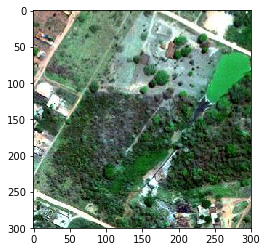

In [4]:
trainDB = currentPath + os.sep + "dataset" +  os.sep + "train20"
valDB = currentPath + os.sep + "dataset" +  os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
DenseNetWeightsPretrained = currentPath + os.sep + "DenseNet-BC-161-48-no-top.h5"


model_name = "DenseNet-161"
classList = os.listdir(trainDB)
classList.sort()

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_7_8_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00032
batch_size = 20
num_epochs = 700
pre_train_epochs = 20

num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 224, 224, 3
num_categories = len(classList)

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval = 0.)
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 927 images belonging to 62 classes.
Found 305 images belonging to 62 classes.


In [7]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6, 'border_checkpoint': 7, 'burial_site': 8, 'car_dealership': 9, 'construction_site': 10, 'crop_field': 11, 'dam': 12, 'debris_or_rubble': 13, 'educational_institution': 14, 'electric_substation': 15, 'factory_or_powerplant': 16, 'fire_station': 17, 'flooded_road': 18, 'fountain': 19, 'gas_station': 20, 'golf_course': 21, 'ground_transportation_station': 22, 'helipad': 23, 'hospital': 24, 'impoverished_settlement': 25, 'interchange': 26, 'lake_or_pond': 27, 'lighthouse': 28, 'military_facility': 29, 'multi-unit_residential': 30, 'nuclear_powerplant': 31, 'office_building': 32, 'oil_or_gas_facility': 33, 'park': 34, 'parking_lot_or_garage': 35, 'place_of_worship': 36, 'police_station': 37, 'port': 38, 'prison': 39, 'race_track': 40, 'railway_bridge': 41, 'recreational_facility': 42, 'road_bridge': 43, 'runway': 44, 'shipyard': 45, 'shopping_mall': 46, 'sin

In [8]:
convcnt = 1
def bn_relu_conv(x, filters, kernel_size):
    global convcnt
    convcnt = convcnt + 1
    x = BatchNormalization(name= "batch_normalization_"+str(convcnt))(x)
    x = ReLU()(x) 
    x = Conv2D(filters, kernel_size, padding="same", name= "conv2d_"+str(convcnt), use_bias=False)(x)
    return x

In [9]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_relu_conv(tensor, 4*k, 1)
        x = bn_relu_conv(x, k, 3)
        tensor = Concatenate()([tensor, x])
    return tensor

In [10]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = bn_relu_conv(x, f, 1)
    x = AvgPool2D(2, strides=2, padding="same")(x)
    return x

In [11]:
def densenet_161( imageShape, weights):
    k = 48
    theta = 0.5
    repetitions = [6, 12, 36, 24]

    input = Input(shape=(imageShape))
    x = ZeroPadding2D(padding=(3, 3))(input)
    x = Conv2D(2*k, 7, strides=2, padding="valid", name="conv2d_1", use_bias=False)(x)
    x = BatchNormalization(name= "batch_normalization_input")(x)
    x = ReLU()(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPool2D(3, strides=2, padding="valid")(x)

    for reps in repetitions:
        denseBlock = dense_block(x, k, reps)
        x = transition_layer(denseBlock, theta)

    model = Model(input, denseBlock)
    model.load_weights(weights, by_name=True)
    
    x = GlobalAvgPool2D()(denseBlock)
    output = Dense(num_categories, activation="softmax")(x)
    model = Model(input, output)
        
    return model



In [12]:
model = densenet_161((img_rows, img_cols, img_channel), DenseNetWeightsPretrained)

model.summary()
#plot_model(model, show_shapes=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 96) 14112       zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_input (Batc (None, 112, 112, 96) 384         conv2d_1[0][0]                   
___________

In [13]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='binary_crossentropy', metrics=[tensorflow.keras.metrics.CategoricalAccuracy()])

In [14]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    verbose=1)

Epoch 1/700
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
4/4 [==============================] - 65s 16s/step - loss: 0.0825 - categorical_accuracy: 0.0375 - val_loss: 0.0826 - val_categorical_accuracy: 0.0125
Epoch 2/700
4/4 [==============================] - 7s 2s/step - loss: 0.0827 - categorical_accuracy: 0.0125 - val_loss: 0.0826 - val_categorical_accuracy: 0.0250
Epoch 3/700
4/4 [==============================] - 7s 2s/step - loss: 0.0831 - categorical_accuracy: 0.0250 - val_loss: 0.0827 - val_categorical_accuracy: 0.0125
Epoch 4/700
4/4 [==============================] - 11s 3s/step - loss: 0.0827 - categorical_accuracy: 0.0149 - val_loss: 0.0828 - val_categorical_accuracy: 0.0125
Epoch 5/700
4/4 [==============================] - 7s 2s/step - loss: 0.0827 - categorical_accuracy: 0.0250 - val_loss: 0.0829 - val_categorical_accuracy: 0.0125
Epoch 6/700
4/4 [==============================] - 7s 2s/step - loss: 0.0829 - categorical_ac

4/4 [==============================] - 7s 2s/step - loss: 0.0795 - categorical_accuracy: 0.0000e+00 - val_loss: 0.0798 - val_categorical_accuracy: 0.0625
Epoch 23/700
4/4 [==============================] - 7s 2s/step - loss: 0.0800 - categorical_accuracy: 0.0125 - val_loss: 0.0834 - val_categorical_accuracy: 0.0375
Epoch 24/700
4/4 [==============================] - 7s 2s/step - loss: 0.0773 - categorical_accuracy: 0.0875 - val_loss: 0.0916 - val_categorical_accuracy: 0.0375
Epoch 25/700
4/4 [==============================] - 7s 2s/step - loss: 0.0757 - categorical_accuracy: 0.0500 - val_loss: 0.1064 - val_categorical_accuracy: 0.0125
Epoch 26/700
4/4 [==============================] - 7s 2s/step - loss: 0.0785 - categorical_accuracy: 0.0750 - val_loss: 0.1851 - val_categorical_accuracy: 0.0500
Epoch 27/700
4/4 [==============================] - 7s 2s/step - loss: 0.0785 - categorical_accuracy: 0.0125 - val_loss: 0.1917 - val_categorical_accuracy: 0.0875
Epoch 28/700
4/4 [=============

Epoch 45/700
4/4 [==============================] - 7s 2s/step - loss: 0.0748 - categorical_accuracy: 0.0250 - val_loss: 0.3045 - val_categorical_accuracy: 0.0250
Epoch 46/700
4/4 [==============================] - 7s 2s/step - loss: 0.0725 - categorical_accuracy: 0.0750 - val_loss: 0.2641 - val_categorical_accuracy: 0.0625
Epoch 47/700
4/4 [==============================] - 7s 2s/step - loss: 0.0740 - categorical_accuracy: 0.0625 - val_loss: 0.2115 - val_categorical_accuracy: 0.0375
Epoch 48/700
4/4 [==============================] - 7s 2s/step - loss: 0.0699 - categorical_accuracy: 0.1250 - val_loss: 0.1914 - val_categorical_accuracy: 0.0500
Epoch 49/700
4/4 [==============================] - 7s 2s/step - loss: 0.0713 - categorical_accuracy: 0.1125 - val_loss: 0.1864 - val_categorical_accuracy: 0.0875
Epoch 50/700
4/4 [==============================] - 7s 2s/step - loss: 0.0694 - categorical_accuracy: 0.1000 - val_loss: 0.1830 - val_categorical_accuracy: 0.0625
Epoch 51/700
4/4 [====

Epoch 90/700
4/4 [==============================] - 7s 2s/step - loss: 0.0662 - categorical_accuracy: 0.1375 - val_loss: 0.1156 - val_categorical_accuracy: 0.0750
Epoch 91/700
4/4 [==============================] - 6s 1s/step - loss: 0.0685 - categorical_accuracy: 0.1791 - val_loss: 0.1273 - val_categorical_accuracy: 0.0625
Epoch 92/700
4/4 [==============================] - 7s 2s/step - loss: 0.0677 - categorical_accuracy: 0.1125 - val_loss: 0.1315 - val_categorical_accuracy: 0.0625
Epoch 93/700
4/4 [==============================] - 7s 2s/step - loss: 0.0678 - categorical_accuracy: 0.1250 - val_loss: 0.1476 - val_categorical_accuracy: 0.0375
Epoch 94/700
4/4 [==============================] - 7s 2s/step - loss: 0.0692 - categorical_accuracy: 0.1375 - val_loss: 0.1164 - val_categorical_accuracy: 0.0250
Epoch 95/700
4/4 [==============================] - 7s 2s/step - loss: 0.0641 - categorical_accuracy: 0.1875 - val_loss: 0.1887 - val_categorical_accuracy: 0.0750
Epoch 96/700
4/4 [====

Epoch 135/700
4/4 [==============================] - 7s 2s/step - loss: 0.0641 - categorical_accuracy: 0.1875 - val_loss: 0.1601 - val_categorical_accuracy: 0.0500
Epoch 136/700
4/4 [==============================] - 7s 2s/step - loss: 0.0639 - categorical_accuracy: 0.1875 - val_loss: 0.1115 - val_categorical_accuracy: 0.0500
Epoch 137/700
4/4 [==============================] - 6s 1s/step - loss: 0.0631 - categorical_accuracy: 0.1642 - val_loss: 0.1061 - val_categorical_accuracy: 0.0250
Epoch 138/700
4/4 [==============================] - 7s 2s/step - loss: 0.0656 - categorical_accuracy: 0.2125 - val_loss: 0.1116 - val_categorical_accuracy: 0.0250
Epoch 139/700
4/4 [==============================] - 7s 2s/step - loss: 0.0642 - categorical_accuracy: 0.1875 - val_loss: 0.1005 - val_categorical_accuracy: 0.0875
Epoch 140/700
4/4 [==============================] - 7s 2s/step - loss: 0.0632 - categorical_accuracy: 0.1750 - val_loss: 0.1282 - val_categorical_accuracy: 0.0375
Epoch 141/700
4/

Epoch 180/700
4/4 [==============================] - 7s 2s/step - loss: 0.0620 - categorical_accuracy: 0.1750 - val_loss: 0.1024 - val_categorical_accuracy: 0.0250
Epoch 181/700
4/4 [==============================] - 7s 2s/step - loss: 0.0560 - categorical_accuracy: 0.2625 - val_loss: 0.1078 - val_categorical_accuracy: 0.0500
Epoch 182/700
4/4 [==============================] - 7s 2s/step - loss: 0.0551 - categorical_accuracy: 0.3125 - val_loss: 0.1266 - val_categorical_accuracy: 0.0625
Epoch 183/700
4/4 [==============================] - 7s 2s/step - loss: 0.0595 - categorical_accuracy: 0.2750 - val_loss: 0.0946 - val_categorical_accuracy: 0.0750
Epoch 184/700
4/4 [==============================] - 7s 2s/step - loss: 0.0555 - categorical_accuracy: 0.3625 - val_loss: 0.0972 - val_categorical_accuracy: 0.0625
Epoch 185/700
4/4 [==============================] - 6s 1s/step - loss: 0.0602 - categorical_accuracy: 0.2985 - val_loss: 0.0963 - val_categorical_accuracy: 0.0625
Epoch 186/700
4/

Epoch 225/700
4/4 [==============================] - 7s 2s/step - loss: 0.0564 - categorical_accuracy: 0.2625 - val_loss: 0.1070 - val_categorical_accuracy: 0.0750
Epoch 226/700
4/4 [==============================] - 7s 2s/step - loss: 0.0519 - categorical_accuracy: 0.3125 - val_loss: 0.1083 - val_categorical_accuracy: 0.0625
Epoch 227/700
4/4 [==============================] - 7s 2s/step - loss: 0.0523 - categorical_accuracy: 0.3375 - val_loss: 0.0964 - val_categorical_accuracy: 0.0625
Epoch 228/700
4/4 [==============================] - 7s 2s/step - loss: 0.0528 - categorical_accuracy: 0.3000 - val_loss: 0.1057 - val_categorical_accuracy: 0.0375
Epoch 229/700
4/4 [==============================] - 7s 2s/step - loss: 0.0590 - categorical_accuracy: 0.2500 - val_loss: 0.1038 - val_categorical_accuracy: 0.0250
Epoch 230/700
4/4 [==============================] - 7s 2s/step - loss: 0.0539 - categorical_accuracy: 0.2875 - val_loss: 0.1053 - val_categorical_accuracy: 0.1250
Epoch 231/700
4/

Epoch 270/700
4/4 [==============================] - 7s 2s/step - loss: 0.0546 - categorical_accuracy: 0.3125 - val_loss: 0.1060 - val_categorical_accuracy: 0.0625
Epoch 271/700
4/4 [==============================] - 7s 2s/step - loss: 0.0514 - categorical_accuracy: 0.3250 - val_loss: 0.1394 - val_categorical_accuracy: 0.0375
Epoch 272/700
4/4 [==============================] - 7s 2s/step - loss: 0.0427 - categorical_accuracy: 0.5000 - val_loss: 0.1446 - val_categorical_accuracy: 0.0625
Epoch 273/700
4/4 [==============================] - 7s 2s/step - loss: 0.0488 - categorical_accuracy: 0.4125 - val_loss: 0.1520 - val_categorical_accuracy: 0.0625
Epoch 274/700
4/4 [==============================] - 7s 2s/step - loss: 0.0509 - categorical_accuracy: 0.3500 - val_loss: 0.1676 - val_categorical_accuracy: 0.0500
Epoch 275/700
4/4 [==============================] - 7s 2s/step - loss: 0.0467 - categorical_accuracy: 0.4125 - val_loss: 0.1711 - val_categorical_accuracy: 0.0500
Epoch 276/700
4/

Epoch 315/700
4/4 [==============================] - 7s 2s/step - loss: 0.0450 - categorical_accuracy: 0.3750 - val_loss: 0.1900 - val_categorical_accuracy: 0.0500
Epoch 316/700
4/4 [==============================] - 7s 2s/step - loss: 0.0447 - categorical_accuracy: 0.4625 - val_loss: 0.1736 - val_categorical_accuracy: 0.0375
Epoch 317/700
4/4 [==============================] - 7s 2s/step - loss: 0.0467 - categorical_accuracy: 0.3750 - val_loss: 0.1691 - val_categorical_accuracy: 0.0625
Epoch 318/700
4/4 [==============================] - 7s 2s/step - loss: 0.0379 - categorical_accuracy: 0.5625 - val_loss: 0.1711 - val_categorical_accuracy: 0.0500
Epoch 319/700
4/4 [==============================] - 7s 2s/step - loss: 0.0438 - categorical_accuracy: 0.4375 - val_loss: 0.1739 - val_categorical_accuracy: 0.0500
Epoch 320/700
4/4 [==============================] - 7s 2s/step - loss: 0.0411 - categorical_accuracy: 0.4750 - val_loss: 0.1713 - val_categorical_accuracy: 0.0500
Epoch 321/700
4/

Epoch 360/700
4/4 [==============================] - 7s 2s/step - loss: 0.0447 - categorical_accuracy: 0.4125 - val_loss: 0.1371 - val_categorical_accuracy: 0.1000
Epoch 361/700
4/4 [==============================] - 7s 2s/step - loss: 0.0367 - categorical_accuracy: 0.5750 - val_loss: 0.1432 - val_categorical_accuracy: 0.0750
Epoch 362/700
4/4 [==============================] - 7s 2s/step - loss: 0.0374 - categorical_accuracy: 0.5250 - val_loss: 0.1303 - val_categorical_accuracy: 0.0625
Epoch 363/700
4/4 [==============================] - 7s 2s/step - loss: 0.0384 - categorical_accuracy: 0.4750 - val_loss: 0.1248 - val_categorical_accuracy: 0.1000
Epoch 364/700
4/4 [==============================] - 7s 2s/step - loss: 0.0406 - categorical_accuracy: 0.5375 - val_loss: 0.1463 - val_categorical_accuracy: 0.0750
Epoch 365/700
4/4 [==============================] - 7s 2s/step - loss: 0.0314 - categorical_accuracy: 0.5500 - val_loss: 0.1703 - val_categorical_accuracy: 0.0375
Epoch 366/700
4/

Epoch 405/700
4/4 [==============================] - 7s 2s/step - loss: 0.0333 - categorical_accuracy: 0.5250 - val_loss: 0.1313 - val_categorical_accuracy: 0.1500
Epoch 406/700
4/4 [==============================] - 7s 2s/step - loss: 0.0335 - categorical_accuracy: 0.5750 - val_loss: 0.1326 - val_categorical_accuracy: 0.1500
Epoch 407/700
4/4 [==============================] - 6s 2s/step - loss: 0.0389 - categorical_accuracy: 0.4776 - val_loss: 0.1322 - val_categorical_accuracy: 0.1875
Epoch 408/700
4/4 [==============================] - 7s 2s/step - loss: 0.0378 - categorical_accuracy: 0.5250 - val_loss: 0.1196 - val_categorical_accuracy: 0.1375
Epoch 409/700
4/4 [==============================] - 7s 2s/step - loss: 0.0331 - categorical_accuracy: 0.5750 - val_loss: 0.1087 - val_categorical_accuracy: 0.1250
Epoch 410/700
4/4 [==============================] - 7s 2s/step - loss: 0.0359 - categorical_accuracy: 0.5625 - val_loss: 0.1050 - val_categorical_accuracy: 0.1375
Epoch 411/700
4/

Epoch 450/700
4/4 [==============================] - 7s 2s/step - loss: 0.0286 - categorical_accuracy: 0.6625 - val_loss: 0.1377 - val_categorical_accuracy: 0.1250
Epoch 451/700
4/4 [==============================] - 7s 2s/step - loss: 0.0243 - categorical_accuracy: 0.7375 - val_loss: 0.1294 - val_categorical_accuracy: 0.1125
Epoch 452/700
4/4 [==============================] - 7s 2s/step - loss: 0.0269 - categorical_accuracy: 0.6625 - val_loss: 0.1201 - val_categorical_accuracy: 0.1125
Epoch 453/700
4/4 [==============================] - 7s 2s/step - loss: 0.0330 - categorical_accuracy: 0.5625 - val_loss: 0.1149 - val_categorical_accuracy: 0.1000
Epoch 454/700
4/4 [==============================] - 7s 2s/step - loss: 0.0273 - categorical_accuracy: 0.7125 - val_loss: 0.1178 - val_categorical_accuracy: 0.1500
Epoch 455/700
4/4 [==============================] - 7s 2s/step - loss: 0.0342 - categorical_accuracy: 0.5750 - val_loss: 0.1225 - val_categorical_accuracy: 0.1250
Epoch 456/700
4/

Epoch 495/700
4/4 [==============================] - 7s 2s/step - loss: 0.0192 - categorical_accuracy: 0.8125 - val_loss: 0.1625 - val_categorical_accuracy: 0.0750
Epoch 496/700
4/4 [==============================] - 7s 2s/step - loss: 0.0198 - categorical_accuracy: 0.7875 - val_loss: 0.1546 - val_categorical_accuracy: 0.1125
Epoch 497/700
4/4 [==============================] - 7s 2s/step - loss: 0.0286 - categorical_accuracy: 0.6875 - val_loss: 0.1532 - val_categorical_accuracy: 0.1375
Epoch 498/700
4/4 [==============================] - 6s 2s/step - loss: 0.0222 - categorical_accuracy: 0.7463 - val_loss: 0.1580 - val_categorical_accuracy: 0.1500
Epoch 499/700
4/4 [==============================] - 7s 2s/step - loss: 0.0221 - categorical_accuracy: 0.8250 - val_loss: 0.1520 - val_categorical_accuracy: 0.1625
Epoch 500/700
4/4 [==============================] - 7s 2s/step - loss: 0.0303 - categorical_accuracy: 0.5625 - val_loss: 0.1406 - val_categorical_accuracy: 0.1500
Epoch 501/700
4/

Epoch 540/700
4/4 [==============================] - 7s 2s/step - loss: 0.0257 - categorical_accuracy: 0.6500 - val_loss: 0.1421 - val_categorical_accuracy: 0.1250
Epoch 541/700
4/4 [==============================] - 7s 2s/step - loss: 0.0226 - categorical_accuracy: 0.7125 - val_loss: 0.1515 - val_categorical_accuracy: 0.1125
Epoch 542/700
4/4 [==============================] - 7s 2s/step - loss: 0.0173 - categorical_accuracy: 0.7750 - val_loss: 0.1706 - val_categorical_accuracy: 0.0875
Epoch 543/700
4/4 [==============================] - 6s 1s/step - loss: 0.0220 - categorical_accuracy: 0.7910 - val_loss: 0.1905 - val_categorical_accuracy: 0.1125
Epoch 544/700
4/4 [==============================] - 7s 2s/step - loss: 0.0218 - categorical_accuracy: 0.7625 - val_loss: 0.1870 - val_categorical_accuracy: 0.1000
Epoch 545/700
4/4 [==============================] - 7s 2s/step - loss: 0.0165 - categorical_accuracy: 0.8250 - val_loss: 0.1704 - val_categorical_accuracy: 0.0875
Epoch 546/700
4/

Epoch 585/700
4/4 [==============================] - 6s 1s/step - loss: 0.0186 - categorical_accuracy: 0.7761 - val_loss: 0.1878 - val_categorical_accuracy: 0.1250
Epoch 586/700
4/4 [==============================] - 7s 2s/step - loss: 0.0167 - categorical_accuracy: 0.7875 - val_loss: 0.1663 - val_categorical_accuracy: 0.1125
Epoch 587/700
4/4 [==============================] - 7s 2s/step - loss: 0.0155 - categorical_accuracy: 0.7500 - val_loss: 0.1535 - val_categorical_accuracy: 0.1250
Epoch 588/700
4/4 [==============================] - 7s 2s/step - loss: 0.0201 - categorical_accuracy: 0.7375 - val_loss: 0.1412 - val_categorical_accuracy: 0.1000
Epoch 589/700
4/4 [==============================] - 7s 2s/step - loss: 0.0118 - categorical_accuracy: 0.9000 - val_loss: 0.1353 - val_categorical_accuracy: 0.0875
Epoch 590/700
4/4 [==============================] - 7s 2s/step - loss: 0.0162 - categorical_accuracy: 0.8000 - val_loss: 0.1333 - val_categorical_accuracy: 0.1000
Epoch 591/700
4/

Epoch 630/700
4/4 [==============================] - 7s 2s/step - loss: 0.0118 - categorical_accuracy: 0.8250 - val_loss: 0.1421 - val_categorical_accuracy: 0.1000
Epoch 631/700
4/4 [==============================] - 7s 2s/step - loss: 0.0155 - categorical_accuracy: 0.8625 - val_loss: 0.1384 - val_categorical_accuracy: 0.1125
Epoch 632/700
4/4 [==============================] - 7s 2s/step - loss: 0.0129 - categorical_accuracy: 0.9125 - val_loss: 0.1340 - val_categorical_accuracy: 0.1250
Epoch 633/700
4/4 [==============================] - 7s 2s/step - loss: 0.0125 - categorical_accuracy: 0.8625 - val_loss: 0.1308 - val_categorical_accuracy: 0.1375
Epoch 634/700
4/4 [==============================] - 6s 1s/step - loss: 0.0172 - categorical_accuracy: 0.8060 - val_loss: 0.1313 - val_categorical_accuracy: 0.1500
Epoch 635/700
4/4 [==============================] - 7s 2s/step - loss: 0.0105 - categorical_accuracy: 0.9000 - val_loss: 0.1409 - val_categorical_accuracy: 0.1000
Epoch 636/700
4/

Epoch 675/700
4/4 [==============================] - 7s 2s/step - loss: 0.0095 - categorical_accuracy: 0.8750 - val_loss: 0.1342 - val_categorical_accuracy: 0.1125
Epoch 676/700
4/4 [==============================] - 7s 2s/step - loss: 0.0077 - categorical_accuracy: 0.9250 - val_loss: 0.1367 - val_categorical_accuracy: 0.1000
Epoch 677/700
4/4 [==============================] - 7s 2s/step - loss: 0.0066 - categorical_accuracy: 0.9375 - val_loss: 0.1427 - val_categorical_accuracy: 0.1375
Epoch 678/700
4/4 [==============================] - 7s 2s/step - loss: 0.0077 - categorical_accuracy: 0.9125 - val_loss: 0.1526 - val_categorical_accuracy: 0.1000
Epoch 679/700
4/4 [==============================] - 7s 2s/step - loss: 0.0113 - categorical_accuracy: 0.8500 - val_loss: 0.1584 - val_categorical_accuracy: 0.0750
Epoch 680/700
4/4 [==============================] - 6s 1s/step - loss: 0.0159 - categorical_accuracy: 0.8209 - val_loss: 0.1701 - val_categorical_accuracy: 0.0750
Epoch 681/700
4/

In [15]:
model.save(currentPath + os.sep + "DenseNet161Model.h5")
model.save_weights(currentPath + os.sep + "DenseNet161Weights.h5")

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


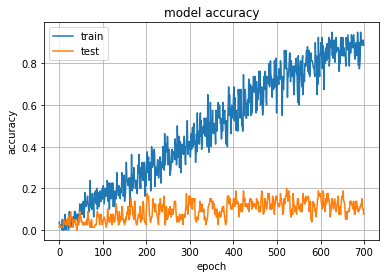

In [16]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

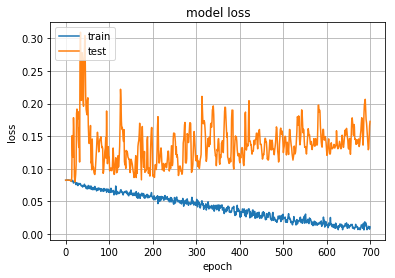

In [17]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [18]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( 224, 224))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_26_1_msrgb.jpg is: airport
file airport_6_0_msrgb.jpg is: impoverished_settlement
file airport_45_3_msrgb.jpg is: tunnel_opening
file airport_55_0_msrgb.jpg is: airport


In [19]:
loadedModel = load_model("DenseNet161Model.h5")

path = trainDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( 224, 224))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
file airport_312_0_msrgb.jpg is: airport
file airport_431_0_msrgb.jpg is: airport
file airport_139_1_msrgb.jpg is: airport
file airport_118_5_msrgb.jpg is: airport
file airport_118_2_msrgb.jpg is: airport
file airport_211_1_msrgb.jpg is: airport
file airport_7_8_msrgb.jpg is: airport
file airport_319_0_msrgb.jpg is: airport
file airport_30_6_msrgb.jpg is: airport
file airport_299_2_msrgb.jpg is: airport
file airport_118_7_msrgb.jpg is: airport
file airport_407_0_msrgb.jpg is: airport
file airport_199_7_msrgb.jpg is: airport
file airport_166_8_msrgb.jpg is: airport
file airport_40_5_msrgb.jpg is: airport
